# Stabilized ICA for transcriptomic data   

In this jupyter notebook, we propose a short example for the use of the algorithm stabilized_ICA.py. We study the extraction of ICA components for a transcriptomic data set gathering NSCLC patients.   

**Note :** To run this jupyter notebook, you first need to extract the data set "data.csv" from the zip file "data.zip" (same directory)

In [1]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 0. Load the data set

This data set was extraced from ["Defining the Biological Basis of Radiomic Phenotypes in Lung Cancer" Grossman et al. 2017](https://elifesciences.org/articles/23421).   
It contains the expression of 21,766 unique genes for 269 patients with Non-small cell lung cancer (NSCLC) treated at the H. Lee Moffitt Cancer Center, Tampa, Florida, USA. Gene expression values were measured on a custom Rosetta/Merck Affymetrix 2.0 microarray chipset and normalized with the robust multi-array average (RMA) algorithm.

In [4]:
df = pd.read_csv("data.csv" , index_col=0)
df.head()

3643     84263       7171      2934     11052      1241  \
RadioGenomic-017  5.205151  7.097989   9.559617  8.396808  7.603719  7.990605   
RadioGenomic-055  5.615738  6.585052   9.777869  9.082415  8.639498  6.781274   
RadioGenomic-227  5.679276  7.747854  10.648704  9.127985  7.369421  7.203773   
RadioGenomic-222  5.317341  7.196276  10.949771  8.098896  7.639882  7.971876   
RadioGenomic-212  7.196904  9.346492   9.673778  9.358636  8.741693  7.616498   

                       6453     57541      9349     11165  ...    643669  \
RadioGenomic-017  10.044401  9.054930  7.383169  8.177010  ...  6.419273   
RadioGenomic-055   9.541826  8.866110  6.422702  7.196294  ...  5.753828   
RadioGenomic-227   8.972255  8.328371  7.269232  7.449183  ...  5.666999   
RadioGenomic-222  10.159637  8.667702  8.474250  7.271477  ...  5.531060   
RadioGenomic-212  10.376653  8.701461  6.601991  7.344651  ...  5.519642   

                      1572      8551     26784     26783     26782     26779  \
RadioGenomic-017  3.809826  6.507880  6.572121  5.400848  5.951391  3.381860   
RadioGenomic-055  4.186127  6.821582  7.031406  4.852417  6.140850  2.629760   
RadioGenomic-227  4.316130  6.637855  6.248824  4.664228  5.767970  2.911470   
RadioGenomic-222  3.403776  7.059419  6.201873  4.690005  6.256286  4.119688   
RadioGenomic-212  3.796049  7.332635  6.050121  4.898523  6.537895  3.600895   

                     26778     26777  100132941  
RadioGenomic-017  9.825584  2.905091   5.622438  
RadioGenomic-055  9.005145  3.366466   5.495330  
RadioGenomic-227  8.674466  3.337194   6.308605  
RadioGenomic-222  9.099659  3.181781   5.740033  
RadioGenomic-212  8.792510  2.945391   5.835411  

[5 rows x 21766 columns]

## 1. Most Stable Transcriptome Dimension (MSTD)   

In order to select the number of ICA components we refer to ["Determining the optimal number of independent components for reproducible transcriptomic data analysis" Kairov et al. 2017](https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-017-4112-9). The idea is to find a trade-off between a sufficiently large number of components to capture all essential information and a restricted dimension to avoid ending up with a lot of very unstable components which only capture noise.   

To do so we plot the stability distribution for a wide range of different number of components M = 5, ... , 100 and we observe which choice of M most satisfies the trade-off.

100%|██████████| 49/49 [1:20:38<00:00, 98.75s/it] 


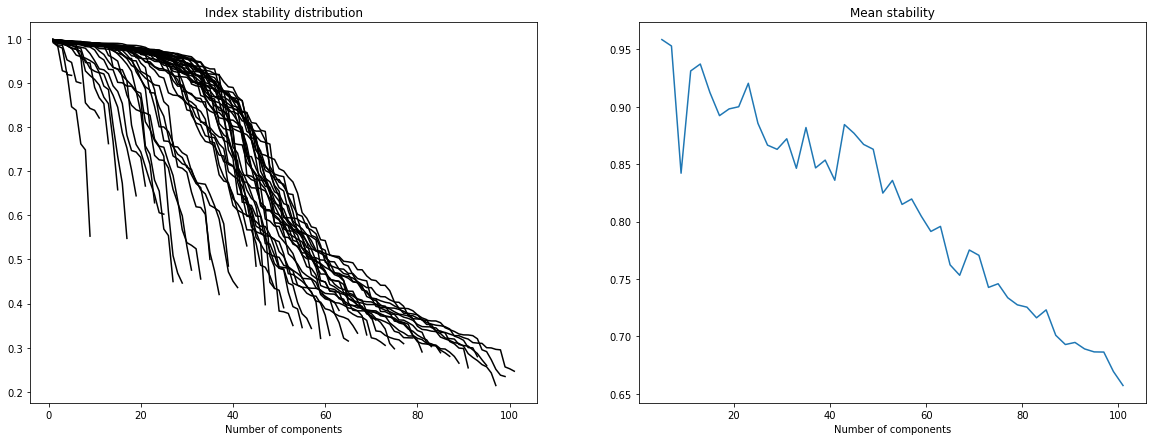

In [6]:
from stabilized_ICA import MSTD
MSTD(df.values , m = 5 , M = 100 , step = 2 , n_runs = 20 , max_iter = 2000)

Please note that in the following we use a rough estimation of the optimal dimension (observed thanks to the graphs above). In fact more sophisticated techniques can be applied to estimate this dimension (ex: two-lines clustering); these can be found in the article cited above.

In [7]:
dim_opt = 45

## 2. Stabilized ICA and Multidimensional Scaling (MDS)   

This stabilized ICA algorithm is a copy of the ICASSO algorithm (implemented in MATLAB) (["ICASSO: software for investigating the reliability of ICA estimates by clustering and visualization" Himber et al.](https://www.cs.helsinki.fi/u/ahyvarin/papers/Himberg03.pd) The main idea is to iterate several times the FastICA algorithm (ex: from sklearn), cluster the results (agglomerative hierarchical clustering) and define the final ICA components as the centrotype of each cluster.   

Some explanation for Multidimensional Scaling can be found on the sklearn page : https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html 

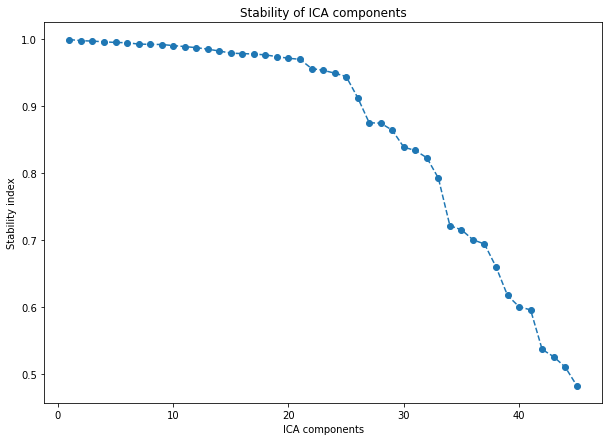

In [10]:
from stabilized_ICA import StabilizedICA 

sICA = StabilizedICA(n_components = dim_opt , max_iter = 2000)
Index, S = sICA.fit(df.values , n_runs = 30 , plot = True)

Text(0.5, 1.0, 'Multidimensional scaling for ICA components')

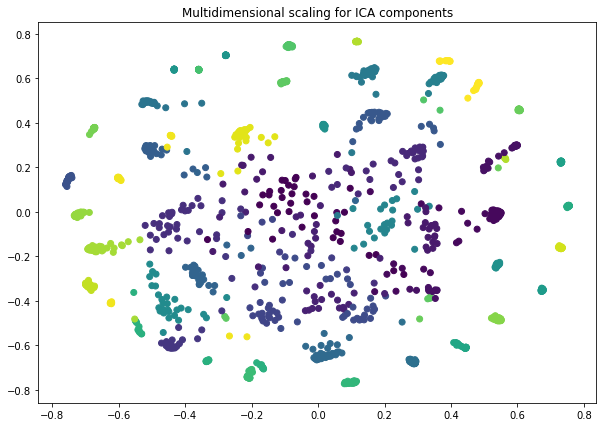

In [11]:
fig , ax = plt.subplots(figsize = (10 , 7))
sICA.projection(ax = ax)

ax.set_title("Multidimensional scaling for ICA components")

In [12]:
Metagenes = pd.DataFrame(S , columns = df.columns , index = ['metagene ' + str(i) for i in range(S.shape[0])])
Metagenes.head()

3643     84263      7171      2934     11052      1241  \
metagene 0 -0.004514  0.000682  0.004061 -0.004558 -0.000299 -0.003574   
metagene 1 -0.003150  0.000333  0.001182 -0.003147 -0.001923 -0.005052   
metagene 2  0.004224  0.001370 -0.000689 -0.000071 -0.009821 -0.001714   
metagene 3  0.003108 -0.002081 -0.005044 -0.009627  0.002516 -0.016981   
metagene 4  0.004929 -0.005325  0.010203  0.003537  0.001274  0.000743   

                6453     57541      9349     11165  ...    643669      1572  \
metagene 0  0.000310  0.001421 -0.002663  0.000951  ...  0.000971 -0.002628   
metagene 1 -0.003001  0.002959 -0.004477 -0.000190  ...  0.002120 -0.021533   
metagene 2  0.001665  0.000803  0.014775 -0.006323  ...  0.004747  0.006383   
metagene 3 -0.025734 -0.002529  0.009019 -0.009710  ... -0.004824 -0.001611   
metagene 4  0.009942 -0.002715  0.001427  0.001936  ... -0.005023  0.001892   

                8551     26784     26783     26782     26779     26778  \
metagene 0 -0.006922 -0.000746  0.002229  0.000832 -0.004122 -0.001093   
metagene 1  0.000645  0.001474  0.001941  0.000977  0.002826 -0.001598   
metagene 2  0.002736 -0.000296 -0.001189 -0.011402 -0.002449 -0.005071   
metagene 3 -0.003896  0.011962  0.008265 -0.001709 -0.003481  0.003484   
metagene 4  0.000079  0.003196  0.003049  0.001241 -0.002441  0.002456   

               26777  100132941  
metagene 0 -0.000109  -0.001923  
metagene 1 -0.002168   0.000135  
metagene 2  0.000760   0.003177  
metagene 3  0.003525   0.005884  
metagene 4 -0.000333   0.000080  

[5 rows x 21766 columns]

We can check that we do obtain sparse ICA components by plotting the distribution of "metagene 1" values (i.e the coefficients associated with "metagene 1" for each feature)

Text(0, 0.5, 'Frequency')

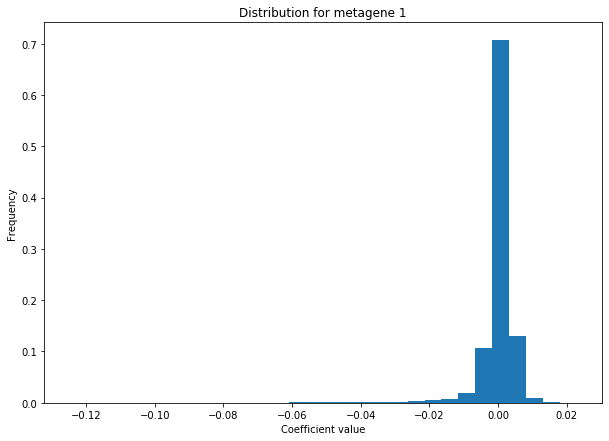

In [17]:
def distribution(Components ,  name , bins):  
    s = Components.loc[name]
    s.hist(bins = bins , weights=np.zeros_like(s) + 1. / s.size , grid = False)
    return

plt.figure(figsize = (10 , 7))
distribution(Metagenes , name = 'metagene 1' , bins = 30)
plt.title("Distribution for metagene 1")
plt.xlabel("Coefficient value")
plt.ylabel("Frequency")